In [1]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from pytorch_pretrained_vit import ViT
import random
import warnings
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import sklearn
import cv2
from PIL import Image


In [2]:
#hyper params
lr = 1e-6
wd = 1e-3
feature_extract = True
bs = 8
test_size = 0.15  # Test set size (20%)
val_size = 0.2   # Validation set size (25%)
num_epoch = 40
classes =['irrelevant','relevant'] #arranged in order of their placement in the folder
num_classes = len(classes)
path = 'Balanced_Binary_Dataset'
hardness_threshold = 0.75
lambda_u = 0.1  # Weighting factor for the unsupervised loss
patience = 4

In [3]:
def transform_denoise(image):
    # Denoising transformation (replace with your denoising algorithm)
    # Example: Apply Gaussian blur with a kernel size of 3
    denoised_image = transforms.functional.gaussian_blur(image, kernel_size=3)
    return denoised_image

def transform_enhance(image):
    # Image enhancement transformation (replace with your enhancement algorithm)
    # Example: Apply contrast enhancement
    enhanced_image = transforms.functional.adjust_contrast(image, contrast_factor=1.5)
    return enhanced_image

In [4]:

def get_dataset(path,val_split,test_split):
    transform_weak = transforms.Compose([transforms.Resize((256,256)),
                                         transforms.Lambda(lambda x: transform_denoise(x)),
                                         transforms.Lambda(lambda x: transform_enhance(x)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                               ])

    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.Lambda(lambda x: transform_denoise(x)),
                                        transforms.Lambda(lambda x: transform_enhance(x)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomCrop(size=256),
                                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset_strong = datasets.ImageFolder(path,transform=transform_strong)
    dataset_weak = datasets.ImageFolder(path,transform=transform_weak)

    trainset_strong,valset_strong,testset_strong = stratified(dataset_strong)
    trainset_weak,valset_weak,testset_weak = stratified(dataset_weak)
    
    print("train strong:",len(trainset_strong),"val strong:",len(valset_strong),"test strong:",len(testset_strong))
    print("train weak:",len(trainset_weak),"val weak:",len(valset_weak),"test strong:",len(testset_weak))

    
    return trainset_strong,valset_strong,testset_strong,trainset_weak,valset_weak,testset_weak

In [5]:
def stratified(dataset):
    # Get the labels and targets from the dataset
    labels = [label for _, label in dataset.samples]
    targets = dataset.targets

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_indices, test_indices = next(stratified_split.split(targets, labels))

    train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)
    testset = torch.utils.data.Subset(dataset, test_indices)
    
    # Further split the train-val dataset into train and validation sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
    train_indices, val_indices = next(stratified_split.split(train_val_dataset, [labels[idx] for idx in train_val_indices]))

    trainset = torch.utils.data.Subset(train_val_dataset, train_indices)
    valset = torch.utils.data.Subset(train_val_dataset, val_indices)
    
    return trainset,valset,testset

In [6]:
def train_model(trainset_strong, valset_strong, trainset_weak,valset_weak, model, criterion, optimizer, scheduler_train, scheduler_val, num_epochs, bs, hardness_threshold):
    dataloaders_strong = {
        'train': data.DataLoader(trainset_strong, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset_strong, batch_size=bs, shuffle=True)
    }

    dataloaders_weak = {
        'train': data.DataLoader(trainset_weak, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset_weak, batch_size=bs, shuffle=True)
    }
    dataset_sizes_strong = {'train': len(trainset_strong), 'val': len(valset_strong)}
    dataset_sizes_weak = {'train': len(trainset_weak), 'val': len(valset_weak)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_bal = 0.0
    epochs_without_improvement = 0  # Reset the counter since there is improvement

    # Lists to store entropy values for each epoch
    entropy_values_train = []
    entropy_values_val = []
    # Lists to store loss of each epoch
    E_loss_train = []
    E_loss_val = []
    # Lists to store balanced accuracy for training and validation phases
    balanced_acc_train = []
    balanced_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            all_labels = []
            all_preds = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                        
            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy
            inputs = None
            labels = None
            c = 0
            # Iterate over data.
            for (inputs_strong, label_strong), (inputs_weak, labels_weak) in zip(dataloaders_strong[phase],dataloaders_weak[phase]):
                if phase == 'train':
                    inputs_strong = inputs_strong.to(device)
                    inputs_weak = inputs_weak.to(device)                
                    labels_weak = labels_weak.to(device)
                else:
                    inputs_val = inputs_strong.to(device)
                    labels_val = label_strong.to(device)
                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    
                    -

                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        unique_classes_pred = np.unique(supervised_preds.cpu().numpy())
                        unique_classes_true = np.unique(labels.cpu().numpy())

                        if np.all(np.in1d(unique_classes_pred, unique_classes_true)):
                            balanced_acc = balanced_accuracy_score(labels.cpu(), supervised_preds.cpu())
                        else:
                            balanced_acc = 0.0  # Assign 0 if classes in y_pred not present in y_true

                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(supervised_preds.cpu().tolist())

                        # Backpropagation and optimization
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    else:
                        
                        # Calculate balanced accuracy for the validation phase without AdaMatch
                        inputs = inputs_val
                        labels = labels_val
                        supervised_outputs = model(inputs)
                        _, supervised_preds = torch.max(supervised_outputs, 1)
                        
                        loss = criterion(supervised_outputs, labels)
                                                    
                        # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                        unique_classes_pred = np.unique(supervised_preds.cpu().numpy())
                        unique_classes_true = np.unique(labels.cpu().numpy())
                        
                        if np.all(np.in1d(unique_classes_pred, unique_classes_true)):
                            balanced_acc = balanced_accuracy_score(labels.cpu(), supervised_preds.cpu())
                        else:
                            balanced_acc = 0.0  # Assign 0 if classes in y_pred not present in y_true
                            
                        all_labels.extend(labels.cpu().tolist())
                        all_preds.extend(supervised_preds.cpu().tolist())

                

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(supervised_preds == labels.data)

                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(supervised_outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            
            if phase == 'train':
                epoch_loss = running_loss / (dataset_sizes_strong[phase]+dataset_sizes_weak[phase]-c)
                epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]+dataset_sizes_weak[phase]-c)
                epoch_entropy /= (dataset_sizes_strong[phase]+dataset_sizes_weak[phase]-c) # Calculate average epoch entropy
            else:
                epoch_loss = running_loss / (dataset_sizes_strong[phase]-c)
                epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]-c)
                epoch_entropy /= (dataset_sizes_strong[phase]-c) # Calculate average epoch entropy
            
            if phase == 'train':
                scheduler_train.step()
                print('Number of skipped:', c)
                print()

                
            if phase == 'val':
                scheduler_val.step(epoch_loss)
                print('Number of skipped:', c)
                print()

            

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase, epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase, balanced_acc))
            print()

            if phase == 'train':
                # Save epoch entropy to the list
                entropy_values_train.append(epoch_entropy.item())
                # Save epoch loss to the list
                E_loss_train.append(epoch_loss)
                # Save epoch balanced loss to the list
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training
            else:
                # Save epoch entropy to the list
                entropy_values_val.append(epoch_entropy.item())
                # Save epoch loss to the list
                E_loss_val.append(epoch_loss)
                # Save epoch balanced loss to the list
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation

            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()

            # Deep copy the model if the validation accuracy improves
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch_val = epoch
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val' and balanced_acc > best_bal:
                best_bal = balanced_acc
                best_epoch_bal = epoch
                
                
            # Early stopping criteria
            if phase == 'val' and epoch > 0:
                if epoch_loss >= E_loss_val[-1]:
                    epochs_without_improvement += 1
                else:
                    epochs_without_improvement = 0

                if epochs_without_improvement >= patience:
                    print('Early stopping due to no improvement in validation loss.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    ) 
                
            # Overfitting criteria
            if phase == 'train' and epoch_loss <= E_loss_train[-1]:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    print('Training stopped due to overfitting.')
                    return (
                        model,
                        entropy_values_train,
                        entropy_values_val,
                        E_loss_train,
                        E_loss_val,
                        balanced_acc_train,
                        balanced_acc_val
                    )
            else:
                epochs_without_improvement = 0
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best Val Acc. was achieved at epoch', best_epoch_val)
    print('Best val Acc: {:4f}'.format(best_bal))
    print('Best Bal Val Acc. was achieved at epoch', best_epoch_bal)



    # Load best model weights
    model.load_state_dict(best_model_wts)

    return (
        model,
        entropy_values_train,
        entropy_values_val,
        E_loss_train,
        E_loss_val,
        balanced_acc_train,
        balanced_acc_val
    )
  

In [7]:
def test_model(model, testset):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []
    c = 0
    
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

              
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / len(testset)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [8]:

def weighted_score_array_adamatch(model,models,dataset_strong, dataset_weak):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader_strong = data.DataLoader(dataset_strong,batch_size=bs,shuffle=True)
    dataloader_weak = data.DataLoader(dataset_weak,batch_size=bs,shuffle=True)
    
    for (inputs_strong, _), (inputs_weak, labels_weak) in zip(dataloader_strong,dataloader_weak):
        inputs_strong = inputs_strong.to(device)
        inputs_weak = inputs_weak.to(device)                
        labels_weak = labels_weak.to(device)
        
        predictions = set()
        with torch.set_grad_enabled(False):
             # AdaMatch steps
            outputs_strong = model(inputs_strong)
            pseudo_labels = torch.softmax(outputs_strong.detach(), dim=1)
            max_probs, pseudo_labels = torch.max(pseudo_labels, dim=1)
            mask = max_probs.ge(0.95).float()

            unsupervised_loss = (criterion(outputs_strong, pseudo_labels) * mask).mean()

            outputs_strong = pseudo_labels.clone().detach()
            inputs = torch.cat([inputs_weak, inputs_strong])
            labels = torch.cat([labels_weak, outputs_strong])

            supervised_outputs = models[0](inputs)
            _, supervised_preds = torch.max(supervised_outputs, 1)
            predictions.add(supervised_preds)  
            
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                supervised_outputs = torch.cat((supervised_outputs,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,supervised_outputs.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,supervised_outputs.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [9]:

def weighted_score_array(model,models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=64,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [10]:
def set_parameter_requires_grad(model, requires_grad=True):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [11]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        # Resnet50
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(model_ft.fc.in_features, num_classes)
        
    elif model_name == "mobilenet":
        # Mobilenet_V2
        model_ft = torchvision.models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    elif model_name == "vgg":
        # VGG16_bn
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == "googlenet":
        # GoogLeNet
        model_ft = torchvision.models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.fc = nn.Linear(1024, num_classes)

    elif model_name == "densenet":
        # Densenet
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, requires_grad=True)
        model_ft.classifier = nn.Linear(1024, num_classes)

    elif model_name == "vit":
        # Vision Transformer (ViT)
        model_ft = ViT('B_16_imagenet1k', pretrained=True)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [12]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda:0


In [13]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Separate the train, val, and test sets
trainset_strong,valset_strong,testset_strong,trainset_weak,valset_weak,testset_weak = get_dataset(path, val_size, test_size)

train strong: 21068 val strong: 5267 test strong: 4648
train weak: 21068 val weak: 5267 test strong: 4648


In [14]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

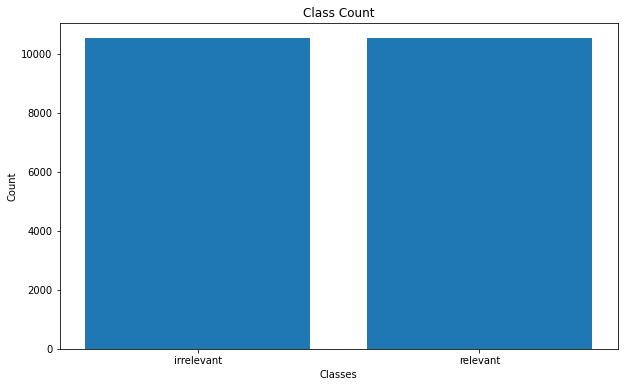

In [15]:
plot_distribution_by_class(trainset_strong, classes)

/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

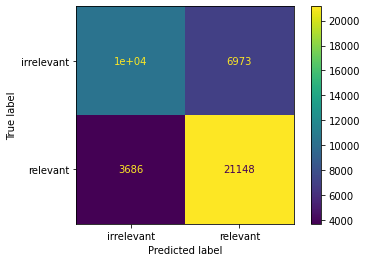

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 0.7735 Acc: 0.6558
val Epoch Entropy: 0.5976
val Balanced Accuracy: 0.7500



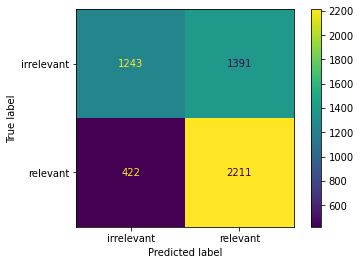

<Figure size 576x432 with 0 Axes>

Epoch 1/39
----------
Number of skipped: 2634

train Loss: 0.4361 Acc: 0.8672
train Epoch Entropy: 0.7085
train Balanced Accuracy: 0.9000



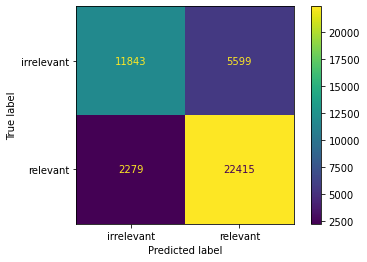

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.0740 Acc: 0.6567
val Epoch Entropy: 0.3844
val Balanced Accuracy: 1.0000



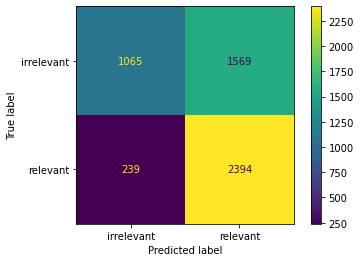

<Figure size 576x432 with 0 Axes>

Epoch 2/39
----------
Number of skipped: 2634

train Loss: 0.4106 Acc: 0.8758
train Epoch Entropy: 0.6427
train Balanced Accuracy: 0.7333



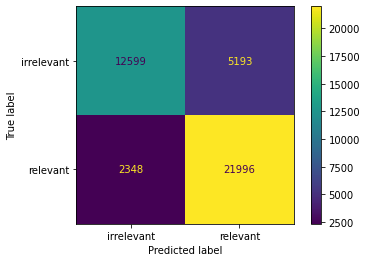

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 0.9622 Acc: 0.6938
val Epoch Entropy: 0.3900
val Balanced Accuracy: 0.7500



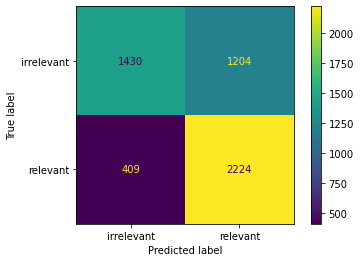

<Figure size 576x432 with 0 Axes>

Epoch 3/39
----------
Number of skipped: 2634

train Loss: 0.3993 Acc: 0.8823
train Epoch Entropy: 0.6146
train Balanced Accuracy: 0.8750



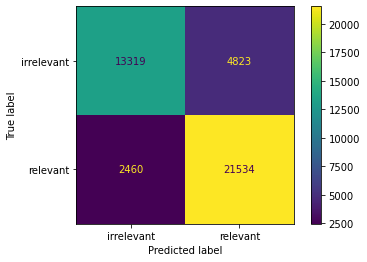

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.1658 Acc: 0.6901
val Epoch Entropy: 0.3029
val Balanced Accuracy: 1.0000



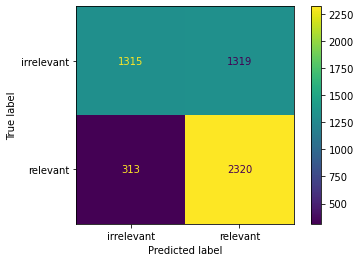

<Figure size 576x432 with 0 Axes>

Epoch 4/39
----------
Number of skipped: 2634

train Loss: 0.3933 Acc: 0.8820
train Epoch Entropy: 0.5986
train Balanced Accuracy: 0.7333



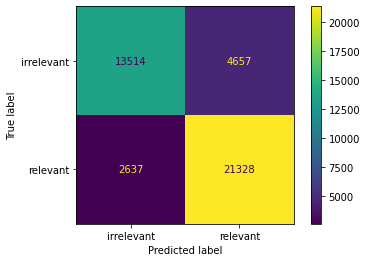

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.1078 Acc: 0.6993
val Epoch Entropy: 0.3068
val Balanced Accuracy: 0.5000



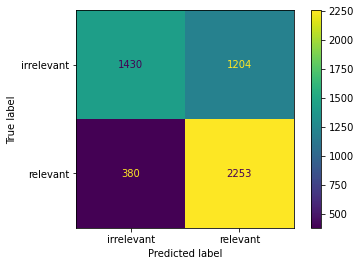

<Figure size 576x432 with 0 Axes>

Epoch 5/39
----------
Number of skipped: 2634

train Loss: 0.3804 Acc: 0.8897
train Epoch Entropy: 0.5786
train Balanced Accuracy: 0.8333



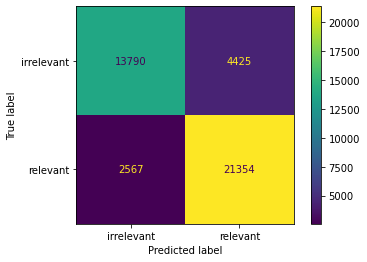

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2784 Acc: 0.6901
val Epoch Entropy: 0.2710
val Balanced Accuracy: 0.2500



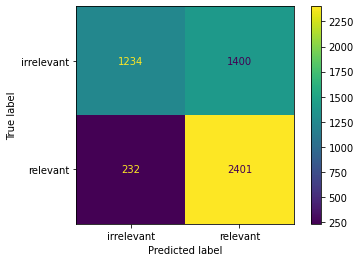

<Figure size 576x432 with 0 Axes>

Epoch 6/39
----------
Number of skipped: 2634

train Loss: 0.3739 Acc: 0.8898
train Epoch Entropy: 0.5635
train Balanced Accuracy: 0.6250



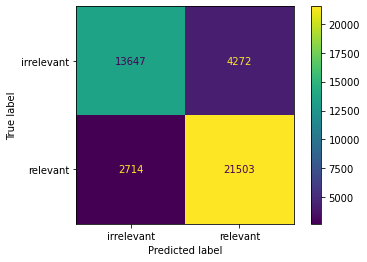

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2416 Acc: 0.7059
val Epoch Entropy: 0.2786
val Balanced Accuracy: 0.0000



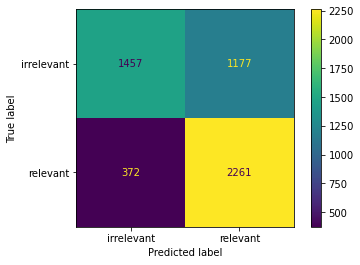

<Figure size 576x432 with 0 Axes>

Epoch 7/39
----------
Number of skipped: 2634

train Loss: 0.3622 Acc: 0.8986
train Epoch Entropy: 0.5516
train Balanced Accuracy: 0.9000



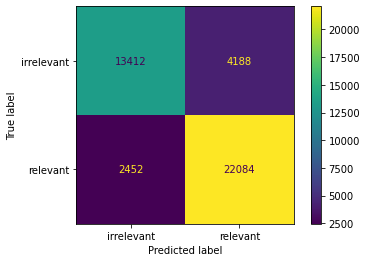

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.0757 Acc: 0.7186
val Epoch Entropy: 0.3286
val Balanced Accuracy: 1.0000



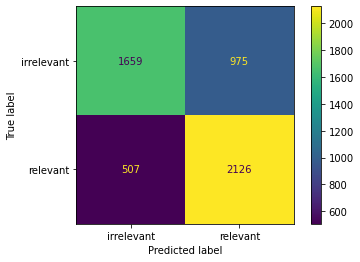

<Figure size 576x432 with 0 Axes>

Epoch 8/39
----------
Number of skipped: 2634

train Loss: 0.3607 Acc: 0.8971
train Epoch Entropy: 0.5517
train Balanced Accuracy: 0.8000



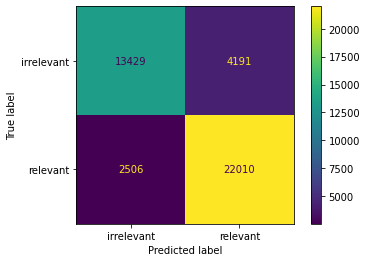

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2155 Acc: 0.7129
val Epoch Entropy: 0.2925
val Balanced Accuracy: 1.0000



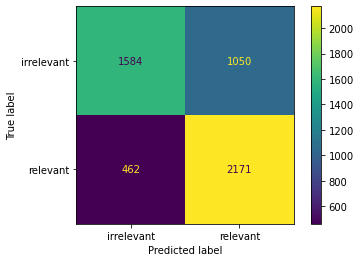

<Figure size 576x432 with 0 Axes>

Epoch 9/39
----------
Number of skipped: 2634

train Loss: 0.3586 Acc: 0.9005
train Epoch Entropy: 0.5501
train Balanced Accuracy: 0.5667



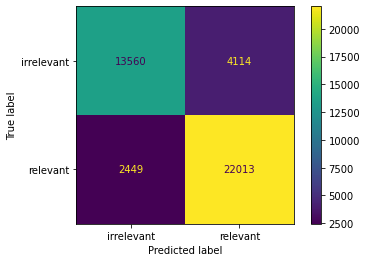

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2463 Acc: 0.7124
val Epoch Entropy: 0.2716
val Balanced Accuracy: 1.0000



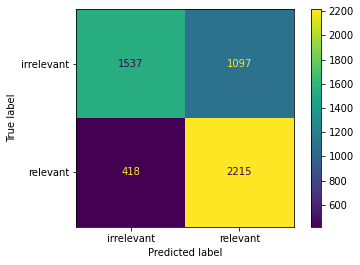

<Figure size 576x432 with 0 Axes>

Epoch 10/39
----------
Number of skipped: 2634

train Loss: 0.3603 Acc: 0.8988
train Epoch Entropy: 0.5486
train Balanced Accuracy: 0.7500



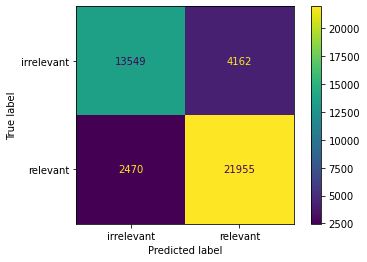

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2786 Acc: 0.7027
val Epoch Entropy: 0.2616
val Balanced Accuracy: 0.5000



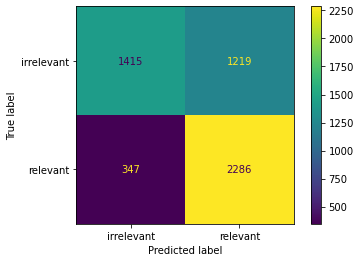

<Figure size 576x432 with 0 Axes>

Epoch 11/39
----------
Number of skipped: 2634

train Loss: 0.3593 Acc: 0.8987
train Epoch Entropy: 0.5484
train Balanced Accuracy: 0.8333



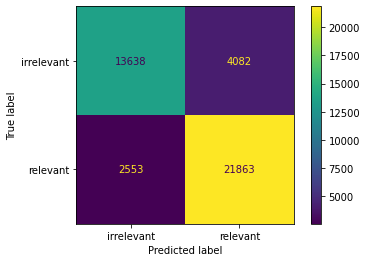

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.1512 Acc: 0.7127
val Epoch Entropy: 0.3012
val Balanced Accuracy: 0.2500



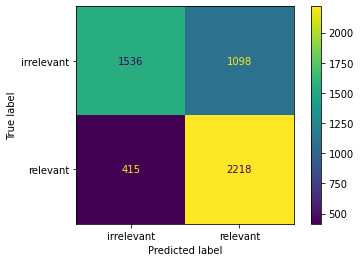

<Figure size 576x432 with 0 Axes>

Epoch 12/39
----------
Number of skipped: 2634

train Loss: 0.3594 Acc: 0.8991
train Epoch Entropy: 0.5459
train Balanced Accuracy: 0.5833



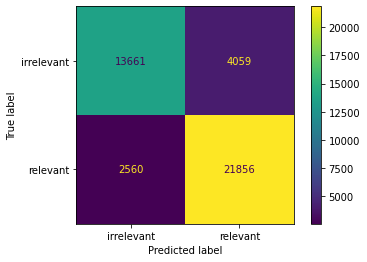

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.3973 Acc: 0.6998
val Epoch Entropy: 0.2375
val Balanced Accuracy: 0.5000



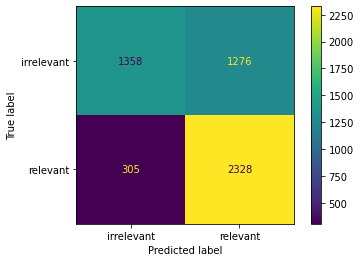

<Figure size 576x432 with 0 Axes>

Epoch 13/39
----------
Number of skipped: 2634

train Loss: 0.3545 Acc: 0.9025
train Epoch Entropy: 0.5416
train Balanced Accuracy: 1.0000



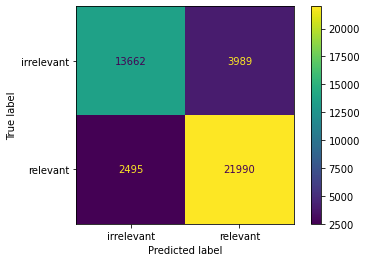

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.1718 Acc: 0.7209
val Epoch Entropy: 0.3033
val Balanced Accuracy: 1.0000



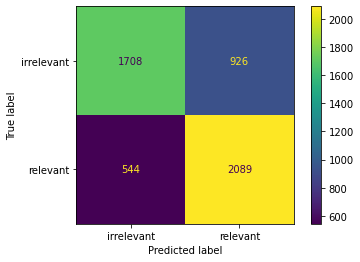

<Figure size 576x432 with 0 Axes>

Epoch 14/39
----------
Number of skipped: 2634

train Loss: 0.3559 Acc: 0.9020
train Epoch Entropy: 0.5421
train Balanced Accuracy: 0.9000



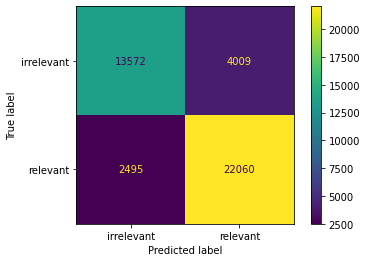

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2287 Acc: 0.7038
val Epoch Entropy: 0.2836
val Balanced Accuracy: 1.0000



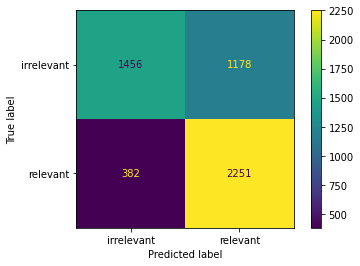

<Figure size 576x432 with 0 Axes>

Epoch 15/39
----------
Number of skipped: 2634

train Loss: 0.3570 Acc: 0.9001
train Epoch Entropy: 0.5418
train Balanced Accuracy: 1.0000



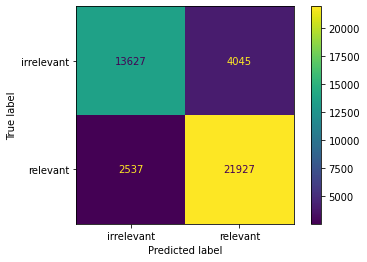

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2422 Acc: 0.7082
val Epoch Entropy: 0.2732
val Balanced Accuracy: 0.7500



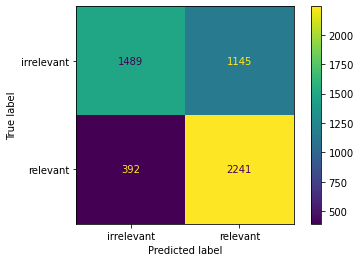

<Figure size 576x432 with 0 Axes>

Epoch 16/39
----------
Number of skipped: 2634

train Loss: 0.3574 Acc: 0.9012
train Epoch Entropy: 0.5419
train Balanced Accuracy: 0.7857



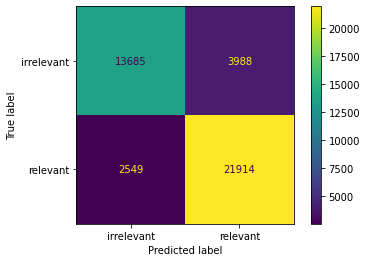

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2522 Acc: 0.7137
val Epoch Entropy: 0.2755
val Balanced Accuracy: 0.0000



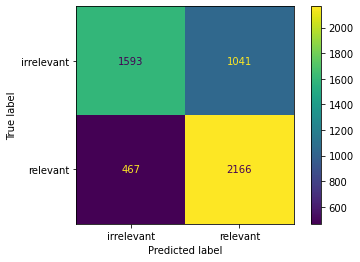

<Figure size 576x432 with 0 Axes>

Epoch 17/39
----------
Number of skipped: 2634

train Loss: 0.3569 Acc: 0.9013
train Epoch Entropy: 0.5425
train Balanced Accuracy: 0.8333



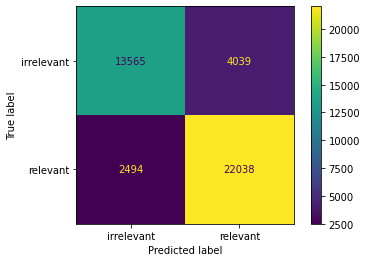

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.4625 Acc: 0.6896
val Epoch Entropy: 0.2263
val Balanced Accuracy: 1.0000



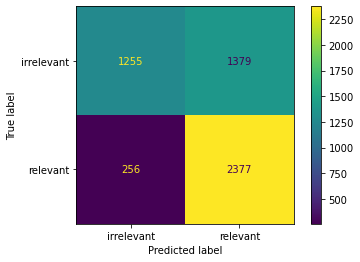

<Figure size 576x432 with 0 Axes>

Epoch 18/39
----------
Number of skipped: 2634

train Loss: 0.3567 Acc: 0.9008
train Epoch Entropy: 0.5416
train Balanced Accuracy: 0.8000



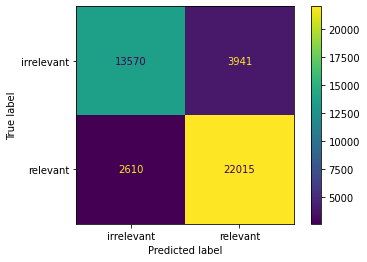

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.3340 Acc: 0.6972
val Epoch Entropy: 0.2534
val Balanced Accuracy: 1.0000



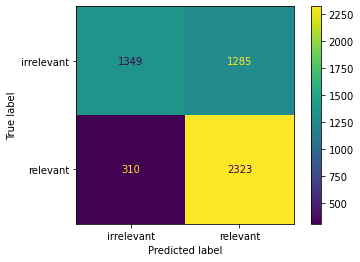

<Figure size 576x432 with 0 Axes>

Epoch 19/39
----------
Number of skipped: 2634

train Loss: 0.3541 Acc: 0.9026
train Epoch Entropy: 0.5405
train Balanced Accuracy: 1.0000



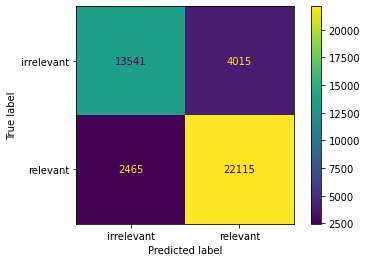

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.3277 Acc: 0.7046
val Epoch Entropy: 0.2508
val Balanced Accuracy: 0.7500



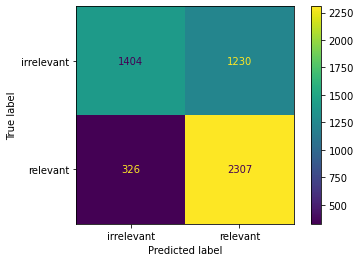

<Figure size 576x432 with 0 Axes>

Epoch 20/39
----------
Number of skipped: 2634

train Loss: 0.3544 Acc: 0.9030
train Epoch Entropy: 0.5402
train Balanced Accuracy: 0.7333



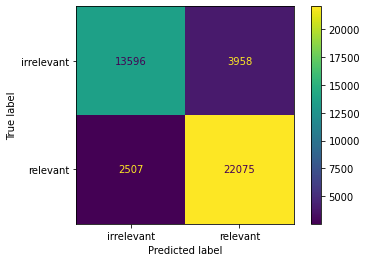

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.3477 Acc: 0.6983
val Epoch Entropy: 0.2526
val Balanced Accuracy: 0.5000



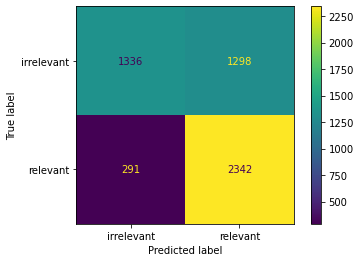

<Figure size 576x432 with 0 Axes>

Epoch 21/39
----------
Number of skipped: 2634

train Loss: 0.3553 Acc: 0.9012
train Epoch Entropy: 0.5412
train Balanced Accuracy: 0.7500



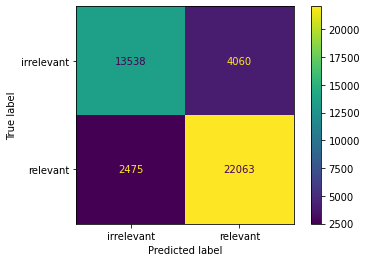

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2431 Acc: 0.7069
val Epoch Entropy: 0.2711
val Balanced Accuracy: 0.0000



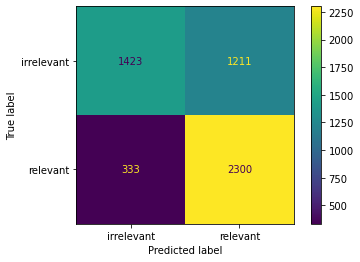

<Figure size 576x432 with 0 Axes>

Epoch 22/39
----------
Number of skipped: 2634

train Loss: 0.3532 Acc: 0.9033
train Epoch Entropy: 0.5407
train Balanced Accuracy: 0.7500



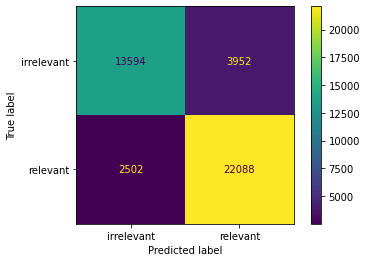

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2457 Acc: 0.7044
val Epoch Entropy: 0.2748
val Balanced Accuracy: 1.0000



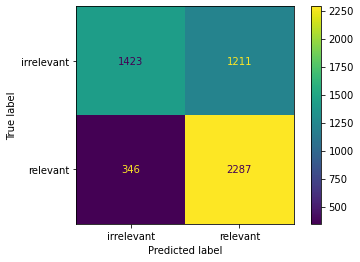

<Figure size 576x432 with 0 Axes>

Epoch 23/39
----------
Number of skipped: 2634

train Loss: 0.3554 Acc: 0.9011
train Epoch Entropy: 0.5409
train Balanced Accuracy: 0.8333



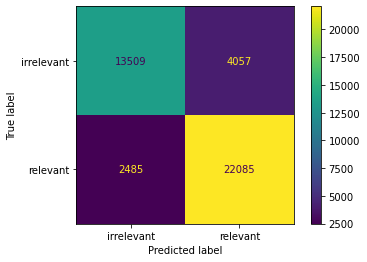

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.3344 Acc: 0.7137
val Epoch Entropy: 0.2731
val Balanced Accuracy: 1.0000



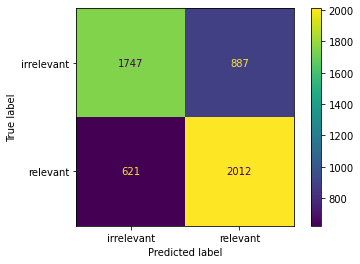

<Figure size 576x432 with 0 Axes>

Epoch 24/39
----------
Number of skipped: 2634

train Loss: 0.3557 Acc: 0.9018
train Epoch Entropy: 0.5406
train Balanced Accuracy: 0.9000



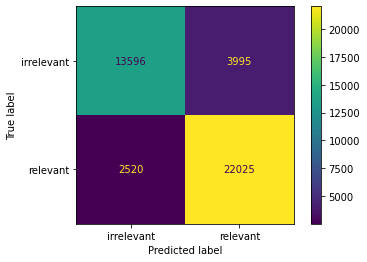

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.3084 Acc: 0.7144
val Epoch Entropy: 0.2761
val Balanced Accuracy: 0.2500



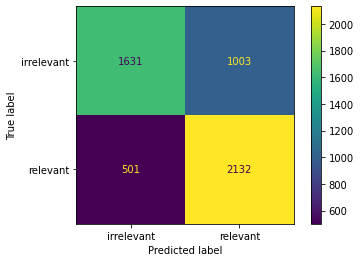

<Figure size 576x432 with 0 Axes>

Epoch 25/39
----------
Number of skipped: 2634

train Loss: 0.3545 Acc: 0.9015
train Epoch Entropy: 0.5404
train Balanced Accuracy: 1.0000



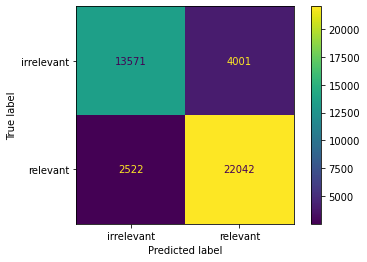

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2901 Acc: 0.7076
val Epoch Entropy: 0.2604
val Balanced Accuracy: 0.5000



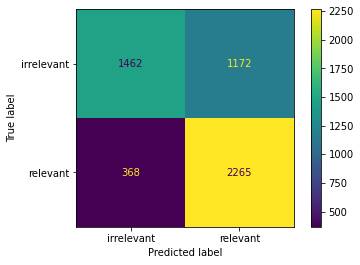

<Figure size 576x432 with 0 Axes>

Epoch 26/39
----------
Number of skipped: 2634

train Loss: 0.3555 Acc: 0.9012
train Epoch Entropy: 0.5409
train Balanced Accuracy: 0.8000



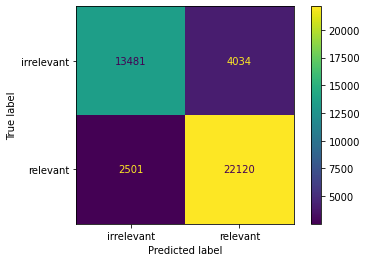

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.3503 Acc: 0.6957
val Epoch Entropy: 0.2456
val Balanced Accuracy: 0.7500



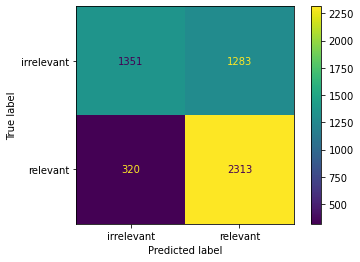

<Figure size 576x432 with 0 Axes>

Epoch 27/39
----------
Number of skipped: 2634

train Loss: 0.3549 Acc: 0.9026
train Epoch Entropy: 0.5396
train Balanced Accuracy: 0.8333



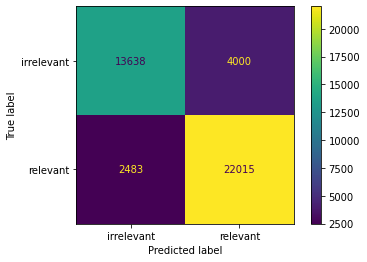

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2555 Acc: 0.7179
val Epoch Entropy: 0.2869
val Balanced Accuracy: 0.0000



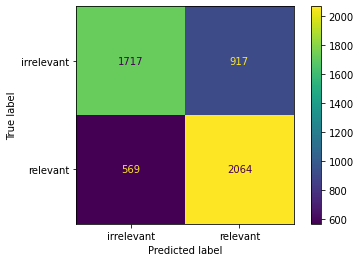

<Figure size 576x432 with 0 Axes>

Epoch 28/39
----------
Number of skipped: 2634

train Loss: 0.3558 Acc: 0.9009
train Epoch Entropy: 0.5413
train Balanced Accuracy: 1.0000



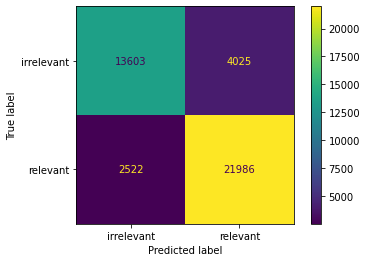

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.1882 Acc: 0.7213
val Epoch Entropy: 0.3017
val Balanced Accuracy: 0.5000



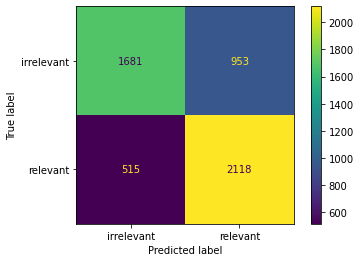

<Figure size 576x432 with 0 Axes>

Epoch 29/39
----------
Number of skipped: 2634

train Loss: 0.3545 Acc: 0.9034
train Epoch Entropy: 0.5391
train Balanced Accuracy: 0.8750



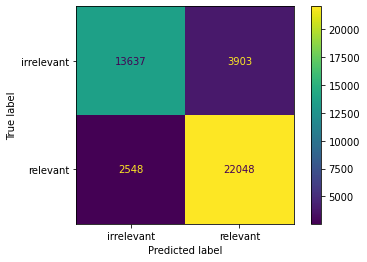

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2329 Acc: 0.7114
val Epoch Entropy: 0.2811
val Balanced Accuracy: 0.7500



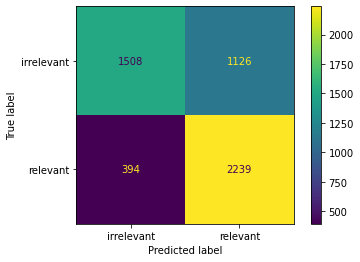

<Figure size 576x432 with 0 Axes>

Epoch 30/39
----------
Number of skipped: 2634

train Loss: 0.3545 Acc: 0.9017
train Epoch Entropy: 0.5401
train Balanced Accuracy: 0.7500



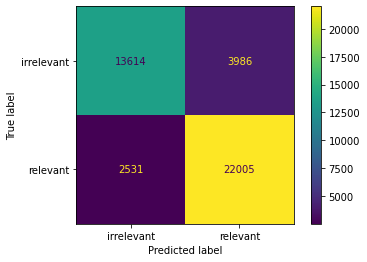

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2410 Acc: 0.7105
val Epoch Entropy: 0.2756
val Balanced Accuracy: 1.0000



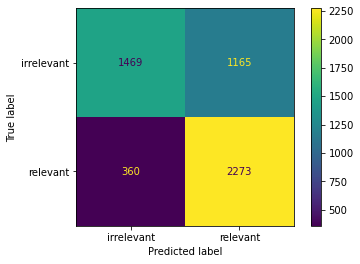

<Figure size 576x432 with 0 Axes>

Epoch 31/39
----------
Number of skipped: 2634

train Loss: 0.3543 Acc: 0.9020
train Epoch Entropy: 0.5399
train Balanced Accuracy: 0.9167



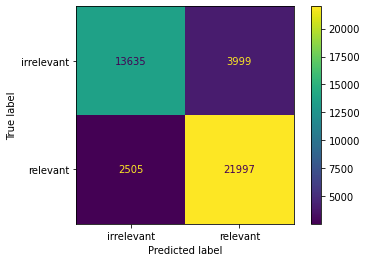

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2844 Acc: 0.7192
val Epoch Entropy: 0.2683
val Balanced Accuracy: 0.0000



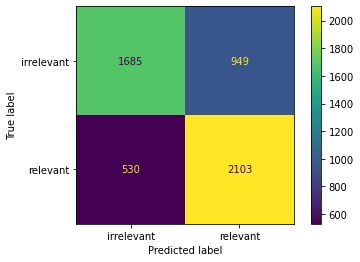

<Figure size 576x432 with 0 Axes>

Epoch 32/39
----------
Number of skipped: 2634

train Loss: 0.3552 Acc: 0.9012
train Epoch Entropy: 0.5394
train Balanced Accuracy: 0.8750



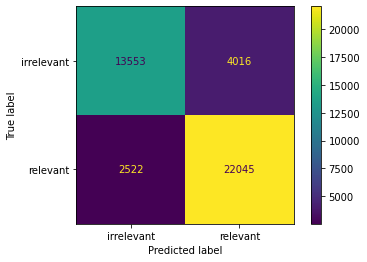

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2668 Acc: 0.7152
val Epoch Entropy: 0.2736
val Balanced Accuracy: 1.0000



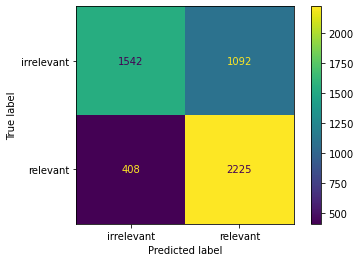

<Figure size 576x432 with 0 Axes>

Epoch 33/39
----------
Number of skipped: 2634

train Loss: 0.3548 Acc: 0.9009
train Epoch Entropy: 0.5408
train Balanced Accuracy: 0.8750



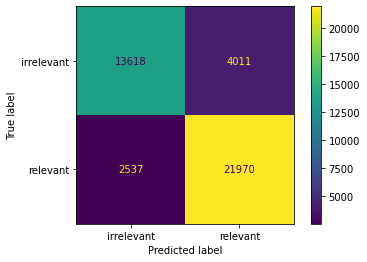

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.4150 Acc: 0.6903
val Epoch Entropy: 0.2404
val Balanced Accuracy: 0.5000



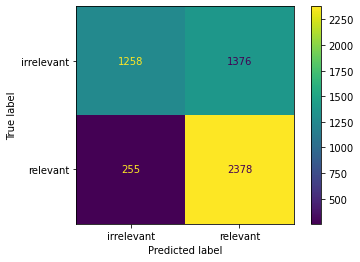

<Figure size 576x432 with 0 Axes>

Epoch 34/39
----------
Number of skipped: 2634

train Loss: 0.3582 Acc: 0.9012
train Epoch Entropy: 0.5408
train Balanced Accuracy: 1.0000



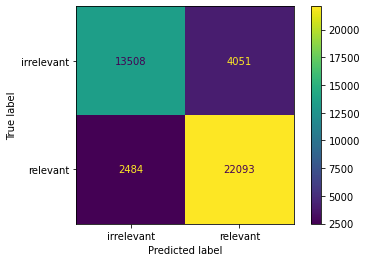

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.3514 Acc: 0.6964
val Epoch Entropy: 0.2533
val Balanced Accuracy: 1.0000



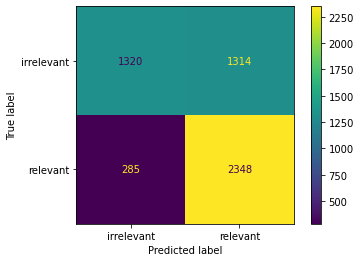

<Figure size 576x432 with 0 Axes>

Epoch 35/39
----------
Number of skipped: 2634

train Loss: 0.3544 Acc: 0.9013
train Epoch Entropy: 0.5419
train Balanced Accuracy: 0.8000



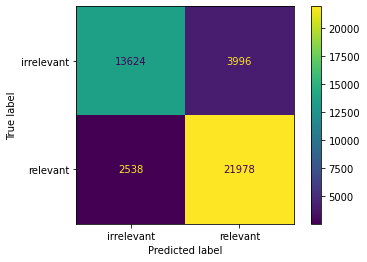

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.4109 Acc: 0.6926
val Epoch Entropy: 0.2391
val Balanced Accuracy: 1.0000



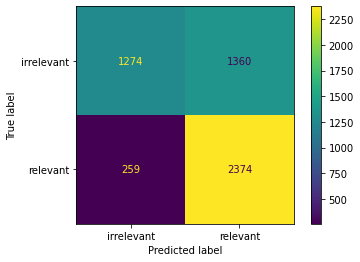

<Figure size 576x432 with 0 Axes>

Epoch 36/39
----------
Number of skipped: 2634

train Loss: 0.3530 Acc: 0.9032
train Epoch Entropy: 0.5395
train Balanced Accuracy: 0.9000



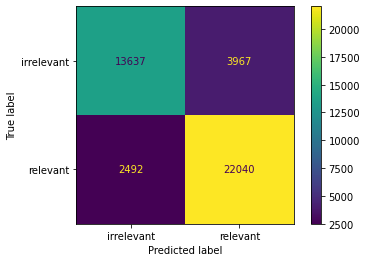

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.4436 Acc: 0.7116
val Epoch Entropy: 0.2299
val Balanced Accuracy: 1.0000



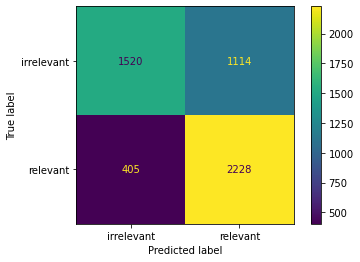

<Figure size 576x432 with 0 Axes>

Epoch 37/39
----------
Number of skipped: 2634

train Loss: 0.3550 Acc: 0.9013
train Epoch Entropy: 0.5398
train Balanced Accuracy: 1.0000



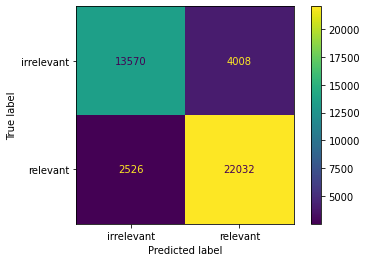

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2798 Acc: 0.7088
val Epoch Entropy: 0.2597
val Balanced Accuracy: 0.5000



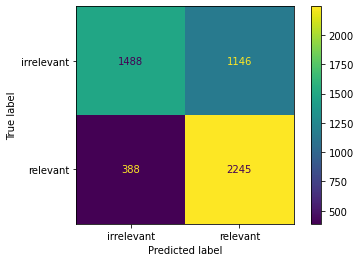

<Figure size 576x432 with 0 Axes>

Epoch 38/39
----------
Number of skipped: 2634

train Loss: 0.3545 Acc: 0.9026
train Epoch Entropy: 0.5393
train Balanced Accuracy: 1.0000



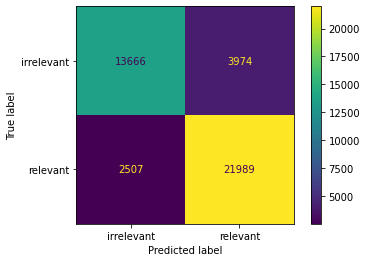

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.2944 Acc: 0.7181
val Epoch Entropy: 0.2729
val Balanced Accuracy: 0.5000



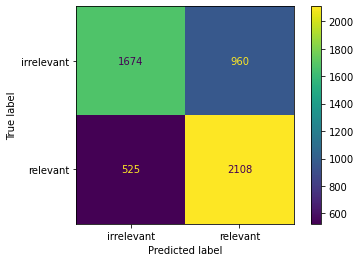

<Figure size 576x432 with 0 Axes>

Epoch 39/39
----------
Number of skipped: 2634

train Loss: 0.3553 Acc: 0.9014
train Epoch Entropy: 0.5399
train Balanced Accuracy: 1.0000



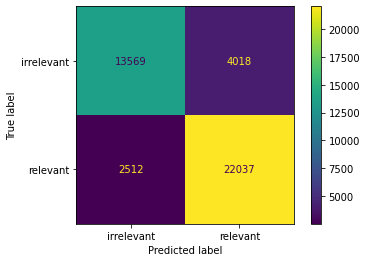

<Figure size 576x432 with 0 Axes>

Number of skipped: 0

val Loss: 1.1509 Acc: 0.7124
val Epoch Entropy: 0.3163
val Balanced Accuracy: 0.5000



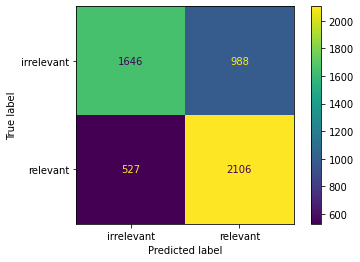

<Figure size 576x432 with 0 Axes>

Training complete in 423m 5s
Best val Acc: 0.721283
Best Val Acc. was achieved at epoch 28
Best val Acc: 1.000000
Best Bal Val Acc. was achieved at epoch 1


In [14]:
model_list = []
for model_name in ["resnet"]:
    
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    model_list.append(model)
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    optimizer = optim.Adamax(params_to_update, lr=lr)

    exp_lr_scheduler_train = lr_scheduler.StepLR(optimizer, step_size=5, gamma=2)
    exp_lr_scheduler_val = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-9)



    
    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val = train_model(trainset_strong, valset_strong,trainset_weak,valset_weak, model, criterion, optimizer, exp_lr_scheduler_train,exp_lr_scheduler_val, num_epoch, bs,hardness_threshold)
    


The Test Accuracy: tensor(0.7119, device='cuda:0')
The Test Balanced Accuracy: 0.7119191049913942


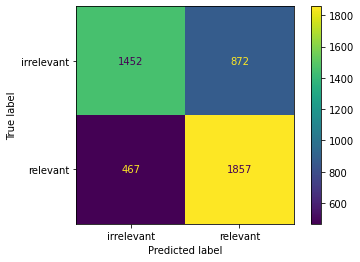

<Figure size 576x432 with 0 Axes>

In [15]:
test_model(model, testset_strong)


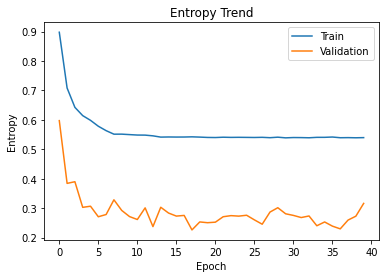

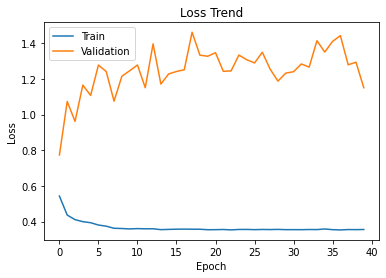

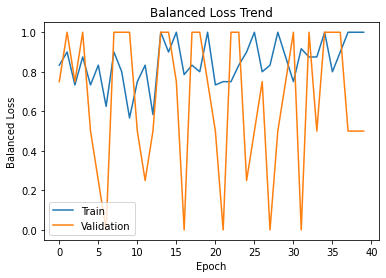

In [16]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Loss')
plt.title('Balanced Loss Trend')
plt.legend()
plt.show()


In [17]:
train_X, train_Y = weighted_score_array_adamatch(model,model_list, trainset_strong, trainset_weak)
test_X, test_Y = weighted_score_array(model, model_list, testset_strong)


In [18]:

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

#Balanced Accuracy
balanced_acc = balanced_accuracy_score(test_Y, predictions)  # Calculate balanced accuracy


print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

print("Dummy Classifier Balanced Accuracy/ Random Baseline:", balanced_acc)



Dummy Classifier Accuracy/ Random Baseline: 0.4995697074010327
Dummy Classifier Balanced Accuracy/ Random Baseline: 0.5032271944922547


Accuracy for SVM: 0.7190189328743546
Balanced Accuracy:0.7190189328743546


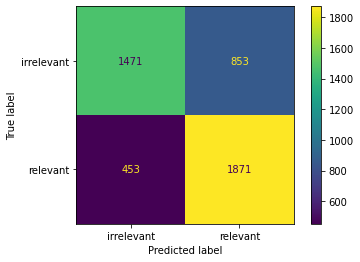

<Figure size 576x432 with 0 Axes>

In [19]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

Accuracy for MLP: 0.7196643717728055
Balanced Accuracy:0.7196643717728055


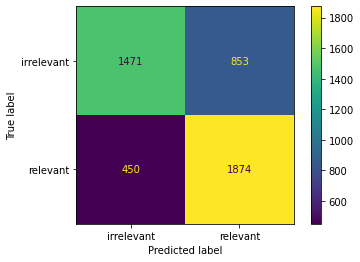

<Figure size 576x432 with 0 Axes>

In [20]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()